In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML

HTML("""
    <style>
    .jp-Stdin-input {
        width: 80% !important;
        height : 1.5em !important;
        font-size : 1em;
        background : white;
        border:1px solid #cccccc;
    }
    </style>
    """)

In [2]:
import numpy as np
import torch
torch.cuda.set_device(0)
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)
from Utils import *

In [3]:
import sys
sys.path.insert(0, 'preprocess/')
import vectorizer

import pickle

In [4]:
vec = pickle.load(open('preprocess/SST/sst.p', 'rb'))
add_frequencies(vec, vec.seq_text['train'])

In [5]:
import model.Attn_Word_Pert as M
Model = M.Model

In [6]:
X, Xt = vec.seq_text['train'], vec.seq_text['test']
y, yt = vec.label['train'], vec.label['test']

In [7]:
X, y = filterbylength(X, y, min_length=5)
Xt, yt = filterbylength(Xt, yt, min_length=5)

Xt, yt = sortbylength(Xt, yt)

In [8]:
pos_weight = 1 #len(y)/sum(y) - 1

In [12]:
from sklearn.metrics import classification_report, f1_score

def train(name='') :
    model = Model(vec.vocab_size, vec.word_dim, 64, dirname='sst', hidden_size=128, pre_embed=vec.embeddings)
    best_f1 = 0.0
    for i in tqdm_notebook(range(10)) :
        loss = model.train(X, y)
        o, he = model.evaluate(Xt)
        o = np.array(o)
        rep = classification_report(yt, (o > 0.5))
        f1 = f1_score(yt, (o > 0.5), pos_label=1)
        print(rep)
        stmt = '%s, %s' % (i, loss)
        if True : #f1 > best_f1 :
            best_f1 = f1
            dirname = model.save_values(add_name=name, save_model=True)
            print("Model Saved", f1)
        else :
            dirname = model.save_values(add_name=name, save_model=False)
            print("Model not saved", f1)
        f = open(dirname + '/epoch.txt', 'a')
        f.write(stmt + '\n')
        f.write(rep + '\n')
        f.close()
    
    return model

In [13]:
train(name='first_final_sst')

Setting Embedding


              precision    recall  f1-score   support

           0       0.83      0.66      0.74       863
           1       0.72      0.87      0.79       862

   micro avg       0.76      0.76      0.76      1725
   macro avg       0.78      0.76      0.76      1725
weighted avg       0.78      0.76      0.76      1725

Model Saved 0.7854889589905363


              precision    recall  f1-score   support

           0       0.88      0.66      0.75       863
           1       0.73      0.91      0.81       862

   micro avg       0.79      0.79      0.79      1725
   macro avg       0.81      0.79      0.78      1725
weighted avg       0.81      0.79      0.78      1725

Model Saved 0.809670781893004


              precision    recall  f1-score   support

           0       0.81      0.82      0.81       863
           1       0.82      0.81      0.81       862

   micro avg       0.81      0.81      0.81      1725
   macro avg       0.81      0.81      0.81      1725
weighted avg       0.81      0.81      0.81      1725

Model Saved 0.81326352530541


              precision    recall  f1-score   support

           0       0.86      0.71      0.78       863
           1       0.75      0.88      0.81       862

   micro avg       0.80      0.80      0.80      1725
   macro avg       0.81      0.80      0.80      1725
weighted avg       0.81      0.80      0.80      1725

Model Saved 0.8132337246531482


              precision    recall  f1-score   support

           0       0.78      0.84      0.81       863
           1       0.83      0.77      0.80       862

   micro avg       0.80      0.80      0.80      1725
   macro avg       0.81      0.80      0.80      1725
weighted avg       0.81      0.80      0.80      1725

Model Saved 0.7968750000000001


              precision    recall  f1-score   support

           0       0.84      0.74      0.78       863
           1       0.77      0.85      0.81       862

   micro avg       0.80      0.80      0.80      1725
   macro avg       0.80      0.80      0.80      1725
weighted avg       0.80      0.80      0.80      1725

Model Saved 0.8076712328767125


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       863
           1       0.80      0.79      0.79       862

   micro avg       0.79      0.79      0.79      1725
   macro avg       0.79      0.79      0.79      1725
weighted avg       0.79      0.79      0.79      1725

Model Saved 0.7937062937062936


              precision    recall  f1-score   support

           0       0.81      0.77      0.79       863
           1       0.78      0.82      0.80       862

   micro avg       0.80      0.80      0.80      1725
   macro avg       0.80      0.80      0.80      1725
weighted avg       0.80      0.80      0.80      1725

Model Saved 0.8002270147559591


              precision    recall  f1-score   support

           0       0.82      0.74      0.78       863
           1       0.76      0.84      0.80       862

   micro avg       0.79      0.79      0.79      1725
   macro avg       0.79      0.79      0.79      1725
weighted avg       0.79      0.79      0.79      1725

Model Saved 0.7982359426681367


              precision    recall  f1-score   support

           0       0.77      0.82      0.79       863
           1       0.80      0.76      0.78       862

   micro avg       0.79      0.79      0.79      1725
   macro avg       0.79      0.79      0.79      1725
weighted avg       0.79      0.79      0.79      1725

Model Saved 0.7794381350866707



# **EVALUATION**

In [15]:
def load_model(dirname) :
    model = Model(vec.vocab_size, vec.word_dim, 64, dirname='sst', hidden_size=128, pre_embed=vec.embeddings)
    model.dirname = dirname
    model.load_values(dirname)
    return model

In [16]:
model = load_model('outputs/attn_word_sst/FriOct1916:55:392018_first_final_sst/')

Setting Embedding


In [17]:
yt_hat, attn_hat = evaluate_and_print(model, Xt, yt)

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       863
           1       0.80      0.76      0.78       862

   micro avg       0.79      0.79      0.79      1725
   macro avg       0.79      0.79      0.79      1725
weighted avg       0.79      0.79      0.79      1725



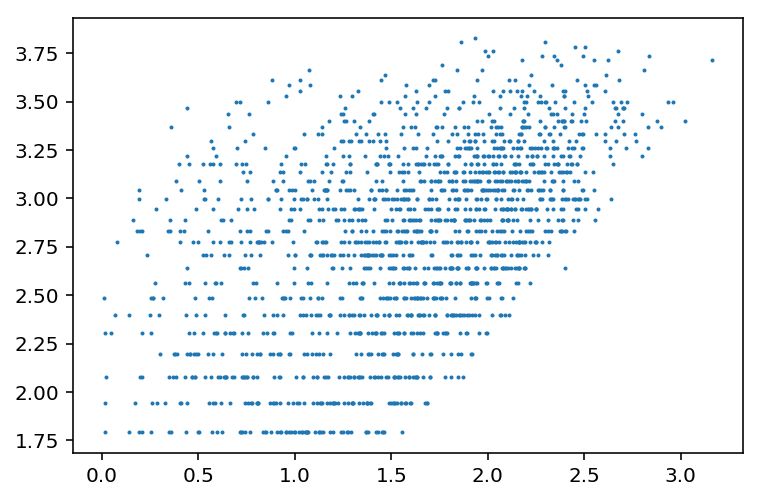

In [18]:
plot_entropy(Xt, attn_hat)

# __Sampling__

In [ ]:
model.vec = vec
sampled_output = model.sampling_top(Xt, sample_vocab=100, topnum=5)

Non Zero :  tensor(33, device='cuda:0', dtype=torch.uint8)


In [ ]:
import pickle
pickle.dump(sampled_output, open(model.dirname + '/sampled.p', 'wb'))

In [ ]:
sampled_output = pickle.load(open(model.dirname + '/sampled.p', 'rb'))

In [ ]:
generate_medians_from_sampling_top(sampled_output, attn_hat, yt_hat)

In [ ]:
distractors = get_distractors(sampled_output, attn_hat)
print_few_distractors(vec, Xt, attn_hat, sampled_output, distractors)

**Gradients**
=============

In [ ]:
grads = model.gradient_mem(Xt)
process_grads(grads)

In [ ]:
plot_grads(Xt, attn_hat, grads)

**Permutation**
===========

In [ ]:
perms = model.permute_attn(Xt)

In [ ]:
plot_permutations(perms, Xt, yt_hat, attn_hat)

**Adversary**
=============

In [ ]:
adversarial_outputs = model.adversarial(Xt, _type='uniform')
ad_y, ad_attn = adversarial_outputs

In [ ]:
jds = plot_adversarial(Xt, yt_hat, attn_hat, adversarial_outputs)

In [ ]:
idx = list(np.where(np.logical_and(np.array(jds) > 0.5, yt_hat > 0.7))[0])[:30]
idx

In [ ]:
n = 734
print_adversarial_example(vec.map2words(X[n]), attn_hat[n], ad_attn[n])
print(yt_hat[n], ad_y[n])

**Copy Runs**
=============

In [ ]:
copy_runs = model.copy_H_run(Xt)

In [ ]:
copy_outputs, copy_attn, copy_H_diff = copy_runs

In [ ]:
plot_attn_diff(Xt, attn_hat, copy_attn, "Attention vs Copy Attention")
plot_y_diff(X, attn_hat, yt_hat, copy_outputs)
plot_attn_diff(Xt, attn_hat, copy_H_diff, "Attention vs H difference")

**Zero Runs**
=============

In [ ]:
zero_runs = model.zero_H_run(Xt)

In [ ]:
zero_outputs, zero_H_diff = zero_runs

In [ ]:
plot_attn_diff(Xt, attn_hat, zero_H_diff)
plot_y_diff(X, attn_hat, yt_hat, zero_outputs)

**Remove and Run**
==================

In [ ]:
remove_outputs = model.remove_and_run(Xt)

In [ ]:
plot_y_diff(Xt, attn_hat, yt_hat, remove_outputs)

**Perturbation**
================

In [ ]:
perturb_outputs = model.perturbation_embedding(Xt)

In [ ]:
plot_pertub_embedding(Xt, attn_hat, yt_hat, perturb_outputs)